<center><h1>Neuro-Fuzzy Computing Final Project: Text Classification with Neural Networks</h1></center>

<center><b><h3>Thomas Katraouras 03215, Ioannis Kalamakis 03325, Alexandros Betsas 03271</h3></b></center>

<br><br><br>

## In this notebook, we go through the code of our project with short descriptions and comments where needed. Further analysis can be found in our report

### All necessary imports

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalMaxPool1D, Conv1D
from keras.initializers import Constant
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras import utils
from keras.regularizers import l2
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
import time

<br><br><br><br>

### First of all before starting, we import the dataset and calculate the average text length, total number of unique words across all articles and we calculate the standard deviation for each class number to see if the dataset is balanced

In [102]:
df = pd.read_csv('news-classification.csv')

# calculate the average number of words per text
word_counts = df['content'].apply(lambda x: len(x.split()))
average_words_per_text = word_counts.mean()

# calculate the number of unique words in all texts
all_words = df['content'].str.split(expand=True).stack()
unique_words_count = len(set(all_words))

# Print the results for words
print(f'Average number of words per text: {average_words_per_text}')
print(f'Number of unique words in all texts: {unique_words_count}')

texts_per_class_level_1 = df['category_level_1'].value_counts()
texts_per_class_level_2 = df['category_level_2'].value_counts()

std_dev_level_1 = texts_per_class_level_1.std()
std_dev_level_2 = texts_per_class_level_2.std()

print(f'Standard Deviation for Category Level 1: {std_dev_level_1}')
print(f'Standard Deviation for Category Level 2: {std_dev_level_2}')

Average number of words per text: 637.4461848493175
Number of unique words in all texts: 303777
Standard Deviation for Category Level 1: 227.0278714426154
Standard Deviation for Category Level 2: 0.9044571927159726


#### It seems the distribution of texts within Level 1 is quite high which signifies a potential imbalance of the dataset
#### Distribution of texts within Level 2 is low, so it seems this category is quite balanced

<br><br>

### Define constants based on our observations

In [98]:
MAX_SEQUENCE_LENGTH = 600  # Max length of input sequences
MAX_NUM_WORDS = 300000  # Max number of words to tokenize

<br>

### DataLoader class, which takes the path to our dataset, text and label column names, test size for data split and it imports the data, keeps only the columns we need, keeps unique label names for classes and subclasses and splits into training / testing sets, then returns everyting.
### This was done so it can be modified to work with any dataset, and return train and test data that will be fed into the preprocessor and neural network

In [107]:
class DataLoader:
    def __init__(self, data_path, text_column='content', label_column_1='category_level_1', label_column_2='category_level_2', test_size=0.2):
        self.data_path = data_path
        self.text_column = text_column
        self.label_column_1 = label_column_1
        self.label_column_2 = label_column_2
        self.test_size = test_size

    def load_data(self):
        df = pd.read_csv(self.data_path)

        X = df[self.text_column].values
        y1 = df[self.label_column_1].values
        y2 = df[self.label_column_2].values

        # Unique labels to be used in label encoding
        y1_label = np.array(df['category_level_1'].unique())
        y2_label = np.array(df['category_level_2'].unique())

        # Split train / test sets
        X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=self.test_size, random_state=42)

        return X_train, y1_train, y2_train, X_test, y1_test, y2_test, y1_label, y2_label

<br>

### TextPreprocessor Class, which is used to preprocess the text (eg. remove case, numbers, remove stopwords, tokenize, pad etc)

### More specifically, for each of its functions:
#### preprocess_text: for each text in the array provided, it converts to lowercase (special characters are removed by the tokenizer itself), replaces all types of hyphens with a space, removes all digits, expands word contradictions (eg. we're is turned into we are), removes all possessives (eg John's is turned into John), tokenizes each sentence in the text and removes stop words based on the nltk corpus, removes single character words/leftover characters. Finally, it returns the array of preprocessed texts
#### fit_on_text: the function actually called by us, it preprocesses the text (using the above function) then fits the preprocessed text to the tokenizer (which also removes special characters)
#### preprocess_text_data: it converts the text to sequences, pads them based on the max sequence length constant, then returns the padded sequences so they can be fed into the neural network
#### plot_token_concentration: plots the concentration of n most frequent tokens in the tokenizer, for visualization purposes
#### remove_stopwords: removes stopwords for the text provided
#### get_vocab_size: gets tokenizer vocabulary size, useful for NN parameters definition

In [3]:
nltk.download('punkt')

class TextPreprocessor:
    def __init__(self, max_num_words=MAX_NUM_WORDS, max_sequence_length=MAX_SEQUENCE_LENGTH):
        self.max_num_words = max_num_words
        self.max_sequence_length = max_sequence_length
        self.custom_filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”‘’' # used by the tokenizer to remove special characters
        self.tokenizer = Tokenizer(filters=self.custom_filters, num_words=self.max_num_words)
        self.stop_words = set(stopwords.words('english')) # stopwords dictionary

    def fit_on_texts(self, texts):
        texts = self.preprocess_text(texts)
        self.tokenizer.fit_on_texts(texts)

    def preprocess_text(self, texts):
        preprocessed_texts = []
        for text in texts:
            text = text.lower()  # convert to lower case
            text = re.sub(r'[-–—]+', ' ', text)  # replace hyphens and en/em-dashes with a space
            text = re.sub(r'\d+', '', text)  # remove digits
            
            # Expand contractions
            contractions_dict = {
                # include all variations of apostrophes
                "’s": " is",
                "’re": " are",
                "’ve": " have",
                "n’t": " not",
                "’ll": " will",
                "’d": " would",
                "’m": " am",
                "won’t": "will not",
                "can’t": "cannot",
                # include the same for standard apostrophes
                "'s": " is",
                "'re": " are",
                "'ve": " have",
                "n't": " not",
                "'ll": " will",
                "'d": " would",
                "'m": " am",
                "won't": "will not",
                "can't": "cannot",
            }
            for contraction, expansion in contractions_dict.items():
                text = re.sub(contraction, expansion, text, flags=re.IGNORECASE)

            text = re.sub(r"('s|’s)\b", "", text)  # remove standalone possessive 's and variations

            # sentence segmentation and stopwords removal
            sentences = sent_tokenize(text)
            processed_sentences = [self.remove_stopwords(sentence) for sentence in sentences]
            processed_text = ' '.join(processed_sentences)  # join the processed sentences

            # remove single character words 
            # (most are already removed by the stopwords remover, this removes left overs)
            processed_text = re.sub(r'\b\w\b', '', processed_text) 
            preprocessed_texts.append(processed_text)
            
        return preprocessed_texts

    def preprocess_text_data(self, texts):
        # convert to sequences, pad them and return them
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_sequence_length)
        return padded_sequences

    def plot_token_concentration(self, num_tokens_to_plot=20):
        word_counts = self.tokenizer.word_counts
        sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        tokens = [item[0] for item in sorted_word_counts]
        frequencies = [item[1] for item in sorted_word_counts]
        
        plt.figure(figsize=(10, 6))
        plt.bar(tokens[:num_tokens_to_plot], frequencies[:num_tokens_to_plot])
        plt.xlabel('Token')
        plt.ylabel('Frequency')
        plt.title('Top {} Tokens in Vocabulary'.format(num_tokens_to_plot))
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def remove_stopwords(self, text):
        return ' '.join([word for word in text.split() if word not in self.stop_words])

    def get_vocab_size(self):
        return len(self.tokenizer.word_index) + 1

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<br>

### We start by utilizing the two classes above to import our dataset and preprocess it (preprocess + tokenize + add padding). We also shuffle it and keep the vocab size and y1_label, y2_label. We plot the concentration of the 30 most seen tokens after tokenization
#### Note: the reason we shuffle the dataset is to prevent the network from seeing only one category first, then another etc and to create more diversity to the data it sees
#### Note: we only fit the tokenizer with the training data instead of the whole dataset, so that the testing data is a simulation of real-world unseen data, which both the tokenizer and the neural network haven't seen before

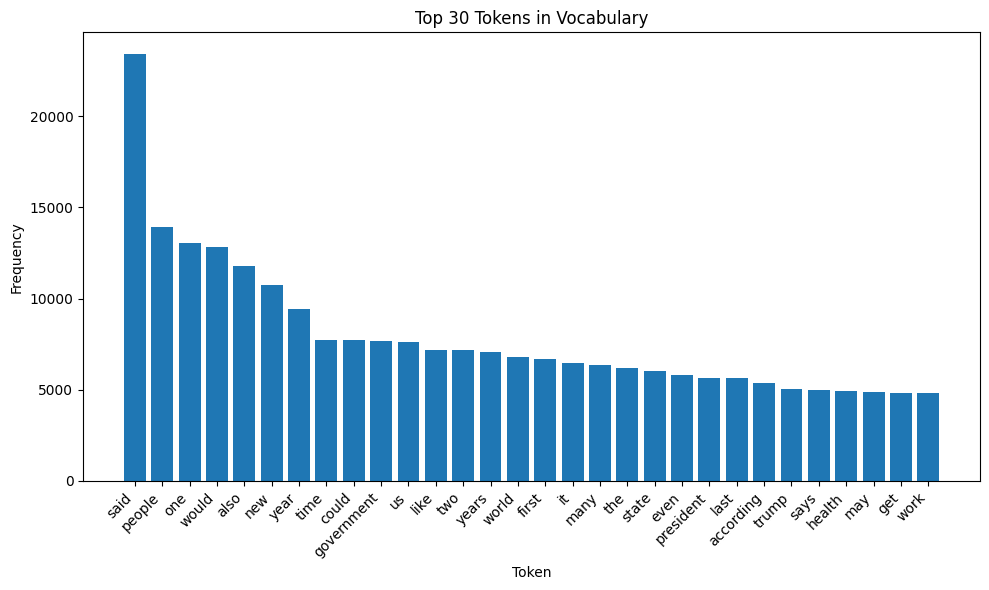

((8733, 600), (2184, 600))

In [4]:
# USING THE 2 ABOVE CLASSES

data_loader = DataLoader("news-classification.csv")

# In the line below, y1_label and y2_label are used later to encode labels
X_train, y1_train, y2_train, X_test, y1_test, y2_test, y1_label, y2_label = data_loader.load_data()

# create shuffled indices
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# shuffle X_train and y_train using the shuffled indices
X_train = X_train[indices]
y1_train = y1_train[indices]
y2_train = y2_train[indices]

# preprocess and tokenize
text_preprocessor = TextPreprocessor()
text_preprocessor.fit_on_texts(X_train) # we only fit on X_train to mimick real world unknown data with X_test
text_preprocessor.plot_token_concentration(30)

# padding
X_train_preprocessed = text_preprocessor.preprocess_text_data(X_train)
X_test_preprocessed = text_preprocessor.preprocess_text_data(X_test)

vocab_size = text_preprocessor.get_vocab_size();

X_train_preprocessed.shape, X_test_preprocessed.shape

<br>

### We encode the labels for both classes and subclasses and turn them to categorical variables

In [5]:
# encode labels for both level 1 and level 2 categories
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()

encoder1.fit(y1_label)
encoder2.fit(y2_label)
y1_train = encoder1.transform(y1_train)
y2_train = encoder2.transform(y2_train)
y1_test = encoder1.transform(y1_test)
y2_test = encoder2.transform(y2_test)

num_classes1 = np.max(y1_train) + 1
num_classes2 = np.max(y2_train) + 1

# convert to categorical
y1_train = utils.to_categorical(y1_train, num_classes1)
y2_train = utils.to_categorical(y2_train, num_classes2)
y1_test = utils.to_categorical(y1_test, num_classes1)
y2_test = utils.to_categorical(y2_test, num_classes2)

<br>
<br>
<br>

## LEVEL 1 (CLASS) NETWORK

<br>

### We train the first network to classify the texts based on level 1 labels

### We define the parameters, then the layers of the network and compile the model. We also split train and validation sets manually instead of using validation_split keras function <br>
### More specifically:
#### We chose 100 embedding dimensions, a batch size of 32 and 25 epochs. The network consists of:
#### An Embedding layer (vocab_size input, embedding_dim output, MAX_SEQUENCE_LENGTH input length and its trainable, since we train our own Embeddings)
#### A Convolutional Layer with 640 filters and a window size of 2. We utilize batch normalization and the activation function is Leaky ReLU.
#### A GlobalMaxPooling Layer after the Convolutional Layer
#### A Dropout Layer with a rate of 0.4
#### A Dense Layer with 640 filters. We utilize batch normalization and the activation function is Leaky ReLU.
#### A Dropout Layer with a rate of 0.3
#### A Dense Layer for the output with 17 filters (for 17 labels) and softmax activation function<br>
### We compile the model with:
#### Categorical Crossentropy as our loss function, RMSProp with a learning rate of 0.0007 and a RHO of 0.5 as our optimizer and categorical accuracy, precision, recall as our metrics<br>

#### Finally, we split 10% of the training dataset as the validation dataset. The reason we do this instead of using validation_split keras function, is to introduce randomness to the validation set, since validation_split does not.

In [87]:
embedding_dim = 100
batch_size = 32
epochs = 25

level1_model = Sequential([
    keras.layers.Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=MAX_SEQUENCE_LENGTH, 
              trainable=True),
    keras.layers.Conv1D(640, 2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(640),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(17, activation='softmax')
])

level1_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0007, rho=0.5),
                    metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

X_train_new, X_val, y1_train_new, y1_val = train_test_split(X_train_preprocessed, y1_train, test_size=0.1, random_state=42)

### Train the model

In [88]:
start_time = time.time()
history_level1 = level1_model.fit(X_train_new, y1_train_new, epochs=epochs, batch_size=batch_size ,validation_data=(X_val, y1_val))
end_time = time.time()

print(f"\n\n----------------------\n\nTraining Took: {(end_time-start_time):.2f} sec")

Epoch 1/25
246/246 [==============================] - 5s 16ms/step - loss: 2.7088 - categorical_accuracy: 0.2313 - precision_9: 0.4902 - recall_9: 0.0957 - val_loss: 3.1872 - val_categorical_accuracy: 0.0881 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/25
246/246 [==============================] - 4s 15ms/step - loss: 1.7152 - categorical_accuracy: 0.4976 - precision_9: 0.6686 - recall_9: 0.3598 - val_loss: 1.7908 - val_categorical_accuracy: 0.4565 - val_precision_9: 0.9121 - val_recall_9: 0.0950
Epoch 3/25
246/246 [==============================] - 4s 15ms/step - loss: 1.3858 - categorical_accuracy: 0.5909 - precision_9: 0.7090 - recall_9: 0.4817 - val_loss: 1.1107 - val_categorical_accuracy: 0.6625 - val_precision_9: 0.7795 - val_recall_9: 0.5217
Epoch 4/25
246/246 [==============================] - 4s 15ms/step - loss: 1.1645 - categorical_accuracy: 0.6571 - precision_9: 0.7575 - recall_9: 0.5655 - val_loss: 1.0477 - val_categorical_accuracy: 0.6922 - val_precisi

### Plot Train and Validation loss and accuracy

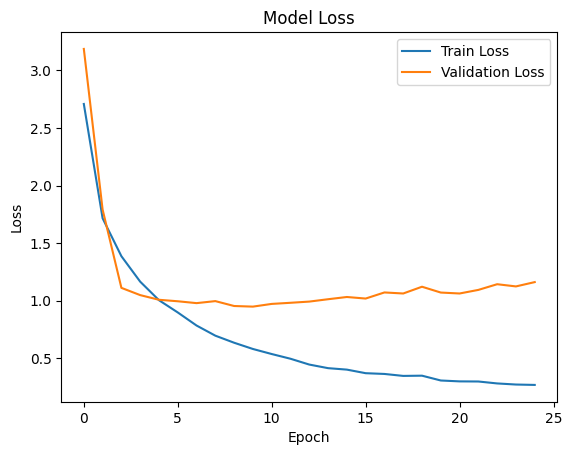

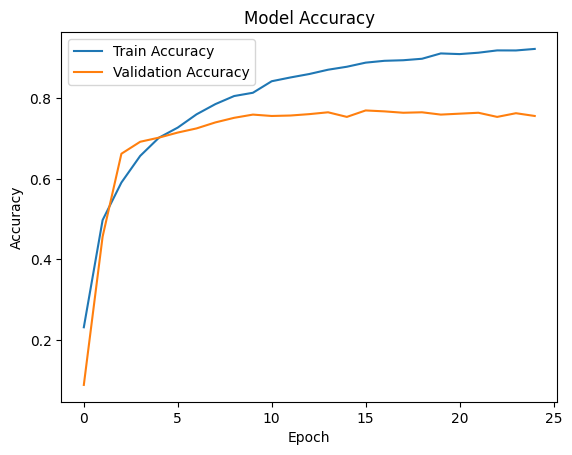

In [89]:
# loss plots
plt.plot(history_level1.history['loss'], label='Train Loss')
plt.plot(history_level1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# accuracy plots
plt.plot(history_level1.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history_level1.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


<br><br>

### Print final network weights after training
#### For each layer, we print the first 5 elements of each array for better readability
#### Obvisouly, layers like GlobalMaxPooling or the activation functions do not have weights, so nothing is printed for them

In [90]:
for layer in level1_model.layers:
    layer_name = layer.name
    weights = layer.get_weights()

    print("Layer Name:", layer_name)

    if len(weights) > 0:
        w = weights[0]
        
        if w.ndim == 1:
            print(w[:5])  # first 5 elements for readability
        else:
            print(w[:5, :5])  # first 5 rows and columns for readability
    else:
        print("No weights found.")

    # Handle bias if present
    if len(weights) > 1:
        bias = weights[1]
        print("\nBias:")
        print(bias[:5])  # first 5 elements for readability
    else:
        print("No bias for this layer.")
    
    print("----------------------------------------------------------------------------------")

Layer Name: embedding_9
[[ 0.03963891 -0.00514397  0.00225287 -0.0874671  -0.0691452 ]
 [ 0.0481843  -0.01704378  0.02247309 -0.06857051 -0.01616324]
 [ 0.03503864  0.00299745  0.00897864 -0.06696893 -0.02323067]
 [ 0.02382465  0.01191436 -0.00999057 -0.06663857 -0.04278738]
 [ 0.01297577 -0.00043177  0.00998729 -0.0415307  -0.02047743]]
No bias for this layer.
----------------------------------------------------------------------------------
Layer Name: conv1d_9
[[[-0.05594615  0.000643   -0.08361456 ...  0.16546719 -0.04561048
   -0.0058559 ]
  [ 0.05350778  0.04937674 -0.0495837  ...  0.05657129  0.12350133
   -0.05568485]
  [-0.02362201  0.01693645 -0.02710921 ...  0.04544612 -0.01073563
    0.04272334]
  [ 0.0847709  -0.02820832  0.01488974 ... -0.05694373 -0.00299152
   -0.0463243 ]
  [-0.06310735  0.0819849  -0.11540084 ... -0.06031746 -0.03869908
   -0.04092087]]

 [[ 0.04766703  0.00197494  0.00798523 ... -0.04387361 -0.04115397
   -0.09946125]
  [ 0.02780514  0.09668719 -0.02

<br>
<br>

### Predict on the test set using the trained model and print statistics
#### After predicting on the test set, we inverse the encoder transform on both the predicted labels and test labels in order to compare them properly and get the statistics

In [109]:
# Predict on test data and print metrics
predictions_level1 = level1_model.predict(X_test_preprocessed)

# Convert predictions to class labels
predicted_labels_level1 = predictions_level1.argmax(axis=1)
predicted_labels_level1_text = encoder1.inverse_transform(predicted_labels_level1) # Reverse predicted label encoding

y1_test_original = np.argmax(y1_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
y1_test_original = encoder1.inverse_transform(y1_test_original)  # Reverse test label encoding

# Calculate metrics
accuracy = accuracy_score(y1_test_original, predicted_labels_level1_text)
precision, recall, fscore, support = score(y1_test_original, predicted_labels_level1_text)

print("\n")
print('Precision: {}'.format(precision))
print("\n")
print('Recall: {}'.format(recall))
print("\n")
print('Fscore: {}'.format(fscore))
print("\n")
print('Support: {}'.format(support))
print("\n")
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print("\n")

69/69 [==============================] - 0s 4ms/step


Precision: [0.73584906 0.78362573 0.75961538 0.76623377 0.72151899 0.76068376
 0.8487395  0.79527559 0.65       0.82857143 0.70666667 0.66486486
 0.74871795 0.66477273 0.7247191  0.88372093 0.82291667]


Recall: [0.57352941 0.83229814 0.78217822 0.6344086  0.67857143 0.8018018
 0.808      0.74264706 0.66101695 0.82857143 0.81538462 0.69101124
 0.81564246 0.76973684 0.62926829 0.83516484 0.91860465]


Fscore: [0.6446281  0.80722892 0.77073171 0.69411765 0.6993865  0.78070175
 0.82786885 0.76806084 0.65546218 0.82857143 0.75714286 0.67768595
 0.78074866 0.71341463 0.67362924 0.85875706 0.86813187]


Support: [ 68 161 101  93  84 111 125 136 118 140  65 178 179 152 205 182  86]


Accuracy: 75.64%




### Count network inference time
#### We call .predict on 20 random samples from the test set and calculate the average inference time

In [78]:
times = []

for _ in range(20):
    # select a random sample from the test set to run this iteration
    random_index = np.random.randint(0, len(X_test_preprocessed))
    random_sample = X_test_preprocessed[random_index]
    
    start_time = time.time()
    level1_model.predict(np.array([random_sample]), verbose=0)
    end_time = time.time()
    
    inference_time = 1000 * (end_time - start_time)
    times.append(inference_time)

average_inference_time = np.mean(times)
print(f"Average Inference Time: {average_inference_time:.2f} ms")

Average Inference Time: 35.54 ms


### Plot a confusion matrix for visualization

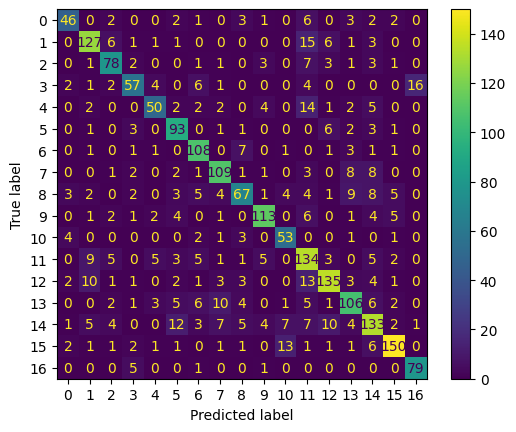

In [42]:
cm = confusion_matrix(y1_test_original, predicted_labels_level1_text)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [43]:
print(y1_test_original[14])
print(predicted_labels_level1_text[12])

religion and belief
society


##### We notice the network gets confused in similar labels, for example it confused 14 (religion and belief) with 12 (society) a lot, which is indeed hard to classify, even for a human, and would probably need a larger sample to improve accuracy

<br>
<br>
<br>

## LEVEL 2 (SUBCLASS) NETWORK

<br>

### We train the first network to classify the texts based on level 2 labels

### We define parameters, then the layers of the network and compile the model. We also split train and validation sets manually instead of using validation_split keras function<br>

### The parameters are the same as above, with the level 2 labels this time, but the Dense Layer for the output has 109 filters (for 109 labels).

In [92]:
embedding_dim = 100
batch_size = 32
epochs = 25

level2_model = Sequential([
    keras.layers.Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=MAX_SEQUENCE_LENGTH, 
              trainable=True),
    keras.layers.Conv1D(640, 2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(640),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(109, activation='softmax')
])

level2_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0007, rho=0.5),
                    metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

X_train_new, X_val, y2_train_new, y2_val = train_test_split(X_train_preprocessed, y2_train, test_size=0.1, random_state=42)

### Train the model

In [93]:
start_time = time.time()
history_level2 = level2_model.fit(X_train_new, y2_train_new, epochs=epochs, batch_size=batch_size ,validation_data=(X_val, y2_val))
end_time = time.time()

print(f"\n\n----------------------\n\nTraining Took: {(end_time-start_time):.2f} sec")

Epoch 1/25
246/246 [==============================] - 5s 16ms/step - loss: 4.9887 - categorical_accuracy: 0.0266 - precision_10: 0.6154 - recall_10: 0.0010 - val_loss: 5.3663 - val_categorical_accuracy: 0.0069 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/25
246/246 [==============================] - 4s 15ms/step - loss: 3.8219 - categorical_accuracy: 0.1621 - precision_10: 0.5979 - recall_10: 0.0358 - val_loss: 4.0558 - val_categorical_accuracy: 0.1465 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/25
246/246 [==============================] - 4s 15ms/step - loss: 2.9607 - categorical_accuracy: 0.3148 - precision_10: 0.6773 - recall_10: 0.1084 - val_loss: 2.6456 - val_categorical_accuracy: 0.3959 - val_precision_10: 0.7273 - val_recall_10: 0.1007
Epoch 4/25
246/246 [==============================] - 4s 15ms/step - loss: 2.4792 - categorical_accuracy: 0.4129 - precision_10: 0.6961 - recall_10: 0.1818 - val_loss: 2.2048 - val_categorical_accuracy

### Plot Train and Validation loss and accuracy

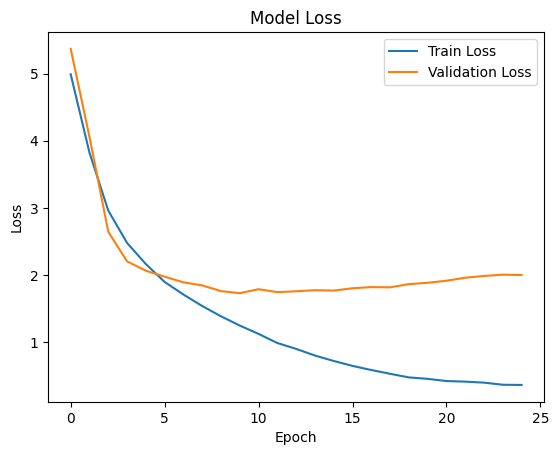

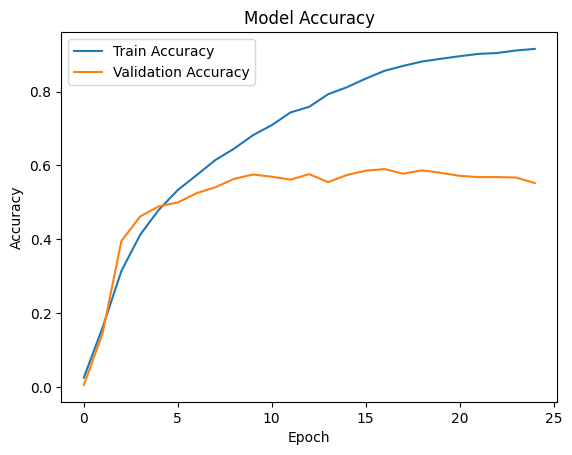

In [94]:
# loss plots
plt.plot(history_level2.history['loss'], label='Train Loss')
plt.plot(history_level2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# accuracy plots
plt.plot(history_level2.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history_level2.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Print final network weights after training
### For each layer, we print the first 5 elements of each array for better readability
### Obvisouly, layers like GlobalMaxPooling or the activation functions do not have weights, so nothing is printed for them

In [95]:
for layer in level2_model.layers:
    layer_name = layer.name
    weights = layer.get_weights()

    print("Layer Name:", layer_name)

    if len(weights) > 0:
        w = weights[0]
        
        if w.ndim == 1:
            print(w[:5])  # first 5 elements for readability
        else:
            print(w[:5, :5])  # first 5 rows and columns for readability
    else:
        print("No weights found.")

    # Handle bias if present
    if len(weights) > 1:
        bias = weights[1]
        print("\nBias:")
        print(bias[:5])  # first 5 elements for readability
    else:
        print("No bias for this layer.")
    
    print("----------------------------------------------------------------------------------")

Layer Name: embedding_10
[[-0.01440887  0.00416537  0.04257254 -0.02412954  0.07780127]
 [-0.01723665 -0.00464624  0.02117972  0.01101948  0.03310762]
 [ 0.00408162 -0.01163095  0.01282269 -0.00832041  0.01638003]
 [-0.01731153 -0.00021933  0.05182431 -0.00470647  0.045844  ]
 [-0.00496667 -0.00270515  0.03173357 -0.03052181  0.04095597]]
No bias for this layer.
----------------------------------------------------------------------------------
Layer Name: conv1d_10
[[[-8.4791511e-02  4.9122784e-02 -6.9724716e-02 ... -1.7643351e-02
    3.5341050e-02  4.7028404e-02]
  [ 3.7653919e-02  8.7409988e-02 -2.4280399e-02 ...  8.1414536e-02
    3.3941459e-02 -5.6879923e-02]
  [ 2.9340670e-03  6.4970315e-02 -5.9964168e-03 ...  2.3992367e-03
   -5.1707566e-02  7.3063381e-02]
  [ 6.8303384e-02 -6.4499512e-02  5.7285405e-03 ... -5.8882046e-02
   -1.3031722e-02 -5.8717770e-04]
  [-7.3031401e-03  7.8750891e-05  1.8985188e-02 ...  7.7426326e-03
    6.6528194e-02  1.3530368e-02]]

 [[ 1.3578951e-03 -3.63

<br>
<br>

### Predict on the test set using the trained model and print statistics
#### After predicting on the test set, we inverse the encoder transform on both the predicted labels and test labels in order to compare them properly and get the statistics

In [96]:
# credict on test data and print metrics
predictions_level2 = level2_model.predict(X_test_preprocessed)

# convert predictions to class labels
predicted_labels_level2 = predictions_level2.argmax(axis=1)

y2_test_original = np.argmax(y2_test, axis=1)  # convert one-hot encoded labels back to categorical labels
y2_test_original = encoder2.inverse_transform(y2_test_original)  # ceverse test label encoding
predicted_labels_level2_text = encoder2.inverse_transform(predicted_labels_level2) # ceverse predicted label encoding

# calculate metrics
accuracy = accuracy_score(y2_test_original, predicted_labels_level2_text)
precision, recall, fscore, support = score(y2_test_original, predicted_labels_level2_text)

print("\n")
print('Precision: {}'.format(precision))
print("\n")
print('Recall: {}'.format(recall))
print("\n")
print('Fscore: {}'.format(fscore))
print("\n")
print('Support: {}'.format(support))
print("\n")
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print("\n")

69/69 [==============================] - 0s 4ms/step


Precision: [0.58333333 0.58823529 0.66666667 0.94117647 0.61538462 0.83333333
 0.7        0.36       0.77777778 0.20512821 0.47619048 0.65517241
 0.61904762 0.54166667 0.6        0.6        0.37931034 0.76470588
 0.9375     0.75       0.42857143 0.89473684 0.76923077 0.61538462
 0.66666667 0.36       0.3125     1.         0.35       0.46666667
 1.         0.76190476 0.08571429 0.41666667 0.375      0.7826087
 0.6        0.82352941 0.7037037  0.78947368 0.375      0.61904762
 0.4        0.53125    0.66666667 0.66666667 0.75       0.51515152
 0.5        0.55555556 0.27777778 0.08823529 0.81818182 0.52631579
 0.82352941 1.         0.58333333 0.875      0.81818182 0.66666667
 0.94117647 0.45454545 0.57142857 0.7        0.47058824 0.35
 0.86666667 0.34782609 0.65217391 0.63636364 0.40625    0.5
 0.84210526 0.45454545 0.82352941 0.89473684 0.57894737 0.7
 0.57894737 0.63636364 0.77272727 0.57142857 0.67567568 0.4
 0.78571429 0.41176471 0

### Count network inference time
#### We call .predict on 20 random samples from the test set and calculate the average inference time

In [97]:
times = []

for _ in range(20):
    # select a random sample from the test set to run this iteration
    random_index = np.random.randint(0, len(X_test_preprocessed))
    random_sample = X_test_preprocessed[random_index]
    
    start_time = time.time()
    level2_model.predict(np.array([random_sample]), verbose=0)
    end_time = time.time()
    
    inference_time = 1000 * (end_time - start_time)
    times.append(inference_time)

average_inference_time = np.mean(times)
print(f"Average Inference Time: {average_inference_time:.2f} ms")

Average Inference Time: 36.51 ms


### Since we have too many classes (109), a confusion matrix would be of no use since it would be too clustered to read any data

<br>
<br>
<br>
<br>
 <br>
 <br>
 <br>
 <br>
 <br>

# Transformers Implementation

### The results above are satisfactory for this dataset, but we wanted to attempt to see how high the accuracy can get. So we decided to utilize transformers, which are pretrained models, for our classification task (essentially we did transfer learning). We chose the distilbert-base-uncased model, since it's a faster variation of the well-performing bert-base-uncased model.<br>

### We did a simple preprocessing by shuffling the dataset, mapping the labels to numbers and tokenizing the data
### We then initialized the model with GPU (if available) and the training parameters:
#### learning rate: 2e-5
#### optimizer: adamw
#### train batch size: 16
#### eval batch size: 64
#### warmup steps: 500
#### weight decay: 1e-5
#### train epochs: 15

<br><br><br>

## For level 1 classification

### Do the necessary preprocessing

In [8]:
def preprocess_function(txt):
    return tokenizer(txt["text"], truncation=True, padding=True, max_length=512)

def pipeline(dataframe):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

pretrained_model = "distilbert-base-uncased"

df = pd.read_csv('news-classification.csv')
df = df[['content', 'category_level_1']].rename(columns={'content': 'text', 'category_level_1': 'label'})

# get unique labels
unique_labels = df['label'].unique()

# shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

# map unique labels to numbers
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# map categories to numerical values
df['label'] = df['label'].map(label_to_index)

# split data into train and validation sets
train_df, val_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42)

# tokenize the text using transformers tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/8733 [00:00<?, ? examples/s]

Map:   0%|          | 0/2184 [00:00<?, ? examples/s]

### Initialize the model

In [10]:
# select gpu if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=17).to(device)

# set up model and initialize trainer
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy='epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=15,
    warmup_steps=500,
    weight_decay=1e-5,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train the model

In [11]:
trainer.train()

Step,Training Loss
500,2.194200
1000,0.960500
1500,0.632400
2000,0.477100
2500,0.364300
3000,0.293900
3500,0.235300
4000,0.186900
4500,0.151900
5000,0.136200


TrainOutput(global_step=8190, training_loss=0.37554137144915495, metrics={'train_runtime': 3006.622, 'train_samples_per_second': 43.569, 'train_steps_per_second': 2.724, 'total_flos': 1.735720876288512e+16, 'train_loss': 0.37554137144915495, 'epoch': 15.0})

### Save the model and tokenizer to disk

In [13]:
# Save the model and tokenizer
model_path = "./level1_model"
tokenizer_path = model_path # It's common to save both in the same directory

trainer.save_model(model_path)
tokenizer.save_pretrained(tokenizer_path)

('./level1_model\\tokenizer_config.json',
 './level1_model\\special_tokens_map.json',
 './level1_model\\vocab.txt',
 './level1_model\\added_tokens.json',
 './level1_model\\tokenizer.json')


### Predict on the test set and print statistics

Map:   0%|          | 0/2184 [00:00<?, ? examples/s]

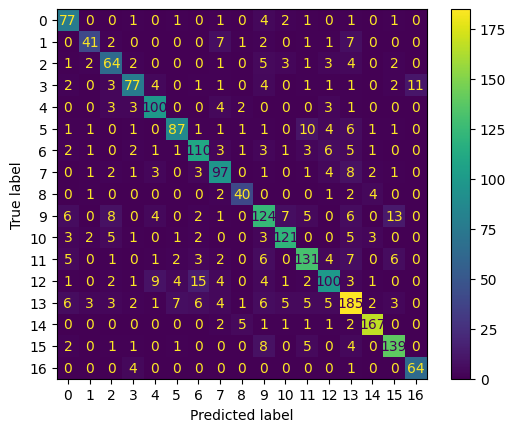

precision: [0.72641509 0.78846154 0.68085106 0.80208333 0.81300813 0.83653846
 0.76923077 0.74615385 0.78431373 0.72093023 0.85815603 0.78443114
 0.7518797  0.74596774 0.92265193 0.82738095 0.85333333]
recall: [0.86516854 0.66129032 0.72727273 0.71296296 0.86206897 0.75
 0.78571429 0.78225806 0.8        0.70454545 0.82876712 0.7797619
 0.68027211 0.75819672 0.92777778 0.86335404 0.92753623]
fscore: [0.78974359 0.71929825 0.7032967  0.75490196 0.83682008 0.79090909
 0.77738516 0.76377953 0.79207921 0.71264368 0.84320557 0.78208955
 0.71428571 0.75203252 0.92520776 0.8449848  0.88888889]
support: [ 89  62  88 108 116 116 140 124  50 176 146 168 147 244 180 161  69]
Accuracy: 0.7893772893772893


In [12]:
tokenized_test = pipeline(val_df)

tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_val)

preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

cm = confusion_matrix(val_df['label'], preds_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

precision, recall, fscore, support = score(val_df['label'], preds_flat)
accuracy = accuracy_score(val_df['label'], preds_flat, normalize=True)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print('Accuracy: {}'.format(accuracy))

<br>
<br>
<br>
<br>
<br>
<br>

## For level 2 classification

### Do the necessary preprocessing

In [14]:
def preprocess_function(txt):
    return tokenizer(txt["text"], truncation=True, padding=True, max_length=512)

def pipeline(dataframe):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

pretrained_model = "distilbert-base-uncased"

df = pd.read_csv('news-classification.csv')
df = df[['content', 'category_level_2']].rename(columns={'content': 'text', 'category_level_2': 'label'})

# get unique labels
unique_labels = df['label'].unique()

# shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

# map unique labels to numbers
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# map categories to numerical values
df['label'] = df['label'].map(label_to_index)

# split data into train and validation sets
train_df, val_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42)

# tokenize the text using transformers tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/8733 [00:00<?, ? examples/s]

Map:   0%|          | 0/2184 [00:00<?, ? examples/s]

### Initialize the model

In [15]:
# select gpu if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=109).to(device)

# set up model and initialize trainer
training_args = TrainingArguments(
    output_dir="./results2",
    save_strategy='epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=15,
    warmup_steps=500,
    weight_decay=1e-5,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train the model

In [16]:
trainer.train()

Step,Training Loss
500,4.462700
1000,3.153200
1500,2.144700
2000,1.538400
2500,1.175600
3000,0.953300
3500,0.764400
4000,0.634700
4500,0.543700
5000,0.457000


TrainOutput(global_step=8190, training_loss=1.0771071288466307, metrics={'train_runtime': 3025.0625, 'train_samples_per_second': 43.303, 'train_steps_per_second': 2.707, 'total_flos': 1.738567893533184e+16, 'train_loss': 1.0771071288466307, 'epoch': 15.0})

### Save the model and tokenizer to disk

In [85]:
# Save the model and tokenizer
model_path = "./saved_model2"
tokenizer_path = model_path # It's common to save both in the same directory

trainer.save_model(model_path)
tokenizer.save_pretrained(tokenizer_path)

('./saved_model2\\tokenizer_config.json',
 './saved_model2\\special_tokens_map.json',
 './saved_model2\\vocab.txt',
 './saved_model2\\added_tokens.json',
 './saved_model2\\tokenizer.json')


### Predict on the test set and print statistics

In [18]:
tokenized_test = pipeline(val_df)

tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_val)

preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

precision, recall, fscore, support = score(val_df['label'], preds_flat)
accuracy = accuracy_score(val_df['label'], preds_flat, normalize=True)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print('Accuracy: {}'.format(accuracy))

Map:   0%|          | 0/2184 [00:00<?, ? examples/s]

precision: [0.88235294 0.54545455 0.73076923 0.52173913 0.68181818 0.56521739
 0.66666667 0.5        0.81481481 0.66666667 0.52173913 0.85
 0.7        0.5        0.5        0.64705882 0.35294118 0.66666667
 0.36       0.94117647 0.33333333 0.15789474 0.63636364 0.5
 0.52631579 0.65       0.47826087 0.72727273 0.65217391 0.54545455
 0.84615385 0.52173913 0.44444444 0.4        0.64       0.78947368
 0.5        0.59259259 0.94736842 0.77272727 0.89473684 0.8
 0.5625     0.44       0.26666667 0.4        0.14285714 0.46153846
 0.56521739 0.55555556 0.53846154 0.53846154 0.28       0.75
 0.70588235 0.77777778 0.6        0.64       0.80952381 0.36363636
 0.52941176 0.73684211 0.68421053 0.73333333 0.84210526 1.
 0.60869565 0.75       0.78947368 0.6        0.6        0.75
 0.66666667 0.8        0.8        0.95454545 0.47058824 0.95454545
 0.7037037  0.85       0.85       0.86956522 0.77777778 0.6875
 0.86363636 0.56521739 0.5625     0.84615385 1.         0.76190476
 0.72       0.45454545 0.645

<br><br><br>

#### In both transformer models, we notice an increase in accuracy compared to our initial implementation, showing that there is potential for more improvement with hyperparameter fine-tuning